In [10]:
import sys
sys.path.insert(1, 'F:/Dev/embedding-quality-analysis/') # Change as needed

In [156]:
import numpy as np
import pandas as pd
from transformers import AutoTokenizer
from torch.nn import Embedding
import matplotlib.pyplot as plt
import torch

from utils.utils import get_saved_embedding

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [89]:
cleaned_data = "../data/words_cleaned.csv"
unique_words_file = "../data/unique_words.csv"

## Get embeddings for the unique words in the dictionary. 
This is easier to do here to not repeat work later

In [150]:
def get_word_embedding(word, tokenizer, embedding):
    tokens = tokenizer.encode(word)
    embeddings = torch.zeros_like(embedding(torch.tensor([0], dtype=torch.long, device=device)))
    for token in tokens:
        token_embedding = embedding(torch.tensor([token],  dtype=torch.long, device=device))
        embeddings += token_embedding
    # embeddings = embeddings / len(tokens)
    # print(embeddings.shape)
    # print(word, tokens, embeddings)
    return embeddings

def get_unique_words_embeddings(tokenizer, embedding):
    unique_words_df = pd.read_csv(unique_words_file)
    # unique_words_df['word_embedding'] = 0.0 #torch.tensor([0.0], dtype=torch.bfloat16)
    word_embedding_dict = {}
    for _, row in unique_words_df.iterrows():
        word = row['word']
        word_embedding = get_word_embedding(word, tokenizer=tokenizer, embedding=embedding)
        word_embedding_dict[word] = word_embedding
        # unique_words_df.at[index, 'word_embedding'] = word_embedding
        # print(word, row['word_embedding'].shape)
    return word_embedding_dict

In [151]:
word_embedding_dict = get_unique_words_embeddings(tokenizer=AutoTokenizer.from_pretrained('EleutherAI/gpt-neox-20b'), embedding=get_saved_embedding('../embeddings/pythia-14m.pth', device=device))
word_embedding_dict['strange']

tensor([[ 0.0424,  0.0932, -0.0096,  0.0227,  0.0401, -0.0103, -0.0342,  0.0372,
         -0.0624,  0.0074, -0.0621,  0.0716,  0.1255,  0.0189, -0.0529, -0.0176,
          0.0552,  0.1028, -0.0197,  0.0119, -0.0393, -0.0280,  0.0154, -0.0170,
         -0.0190, -0.0299,  0.0335,  0.0217,  0.0524,  0.0273, -0.0613,  0.0214,
         -0.0331, -0.0281, -0.0300,  0.0163,  0.0528, -0.0714, -0.0680, -0.0205,
         -0.0282,  0.0040,  0.0097, -0.0481, -0.0229,  0.0079, -0.0123,  0.0351,
          0.0315,  0.0284, -0.0376, -0.0918, -0.0323,  0.0635,  0.0294, -0.0659,
         -0.0017,  0.0439,  0.0151, -0.0533, -0.0031, -0.0442, -0.0415, -0.0057,
          0.0150, -0.0095, -0.0270,  0.0048, -0.0177, -0.0232,  0.0273,  0.0396,
         -0.0469,  0.0370, -0.0060, -0.0464,  0.0600,  0.0801, -0.0181,  0.0410,
         -0.0476,  0.0611, -0.0196,  0.0337, -0.0275, -0.0041,  0.0347,  0.0159,
          0.0265, -0.0155,  0.0380, -0.0163, -0.1071,  0.0433, -0.0278,  0.0209,
          0.0043,  0.0461,  

## Iterate through the analogies (pairComparison)

In [152]:
def evaluate_word_embeddings(word_embedding_dict):
    df = pd.read_csv(cleaned_data)
    df.head()
    for index, row in df.iterrows():
        analogy_embedding_1 = word_embedding_dict[row['word1']] - word_embedding_dict[row['word2']]
        analogy_embedding_2 = word_embedding_dict[row['word3']] - word_embedding_dict[row['word4']]
        cos_sim  = torch.cosine_similarity(analogy_embedding_1, analogy_embedding_2).tolist()[0]
        # print(cos_sim)
        df.loc[index, 'pairwise_cos_sim'] = cos_sim
    # print(df)
    scores = df[['category', 'pairwise_cos_sim']].groupby('category').agg(np.mean)
    return scores

## Plotting code

In [163]:
# scores.set_index('category', inplace=True)
def plot_single_scores(scores):
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(scores.index, scores['pairwise_cos_sim'], color='skyblue')
    plt.xlabel('Category')
    plt.ylabel('Pairwise Cosine Similarity')
    plt.title('Pairwise Cosine Similarity by Category')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

## Running the code

In [159]:
tokenizer_name = 'EleutherAI/gpt-neox-20b'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
embedding = get_saved_embedding('../embeddings/pythia-70m.pth', device=device)
# embedding = Embedding(50600, 128, device=device)

In [160]:
word_embedding_dict = get_unique_words_embeddings(tokenizer=AutoTokenizer.from_pretrained('EleutherAI/gpt-neox-20b'), embedding=embedding)
scores = evaluate_word_embeddings(word_embedding_dict)
scores.head()

,pairwise_cos_sim
category,
capital-common-countries,0.051127
capital-world,0.018832
city-in-state,0.097858
currency,0.080558
family,0.069466


In [166]:
model_names = [
                'pythia-14m',
                'pythia-31m',
                'pythia-70m', 
                'pythia-160m', 
                'pythia-410m', 
                'pythia-1b', 
                'pythia-1.4b', 
                'pythia-2.8b', 
                'pythia-6.9b', 
                'pythia-12b',
                ] 
tokenizer_name = 'EleutherAI/gpt-neox-20b'

pythia-14m


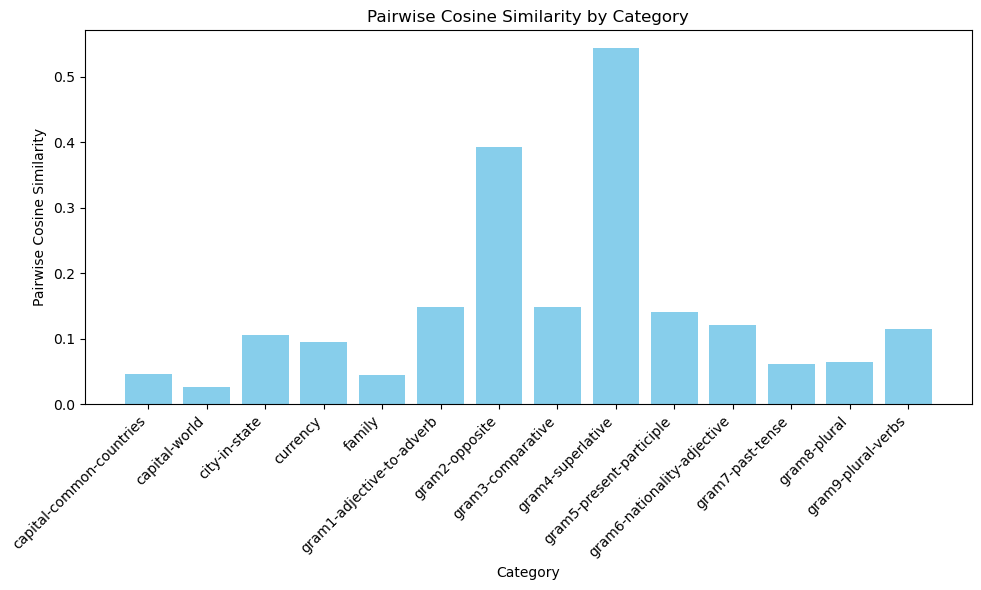

pythia-31m


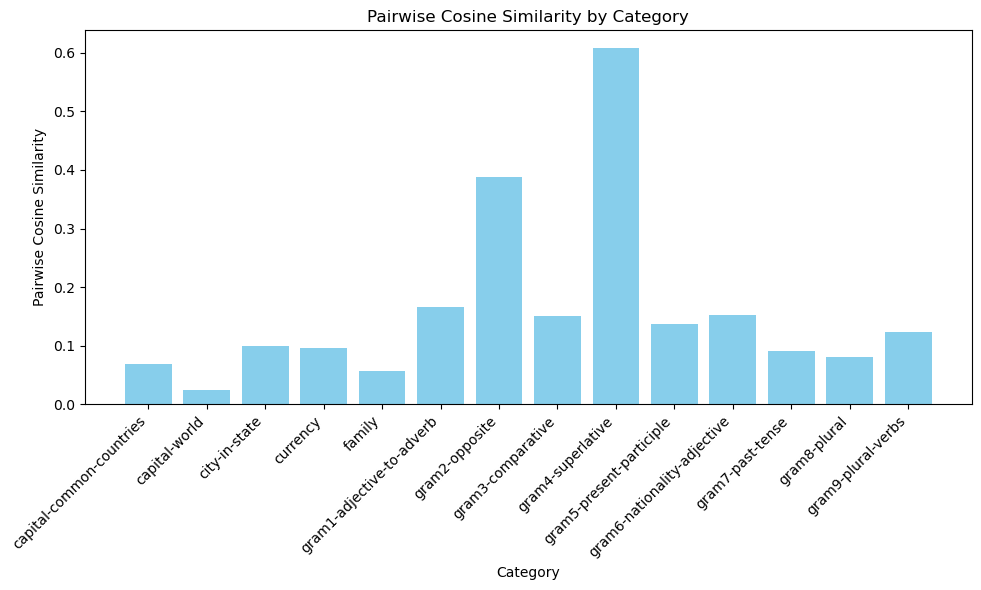

pythia-70m


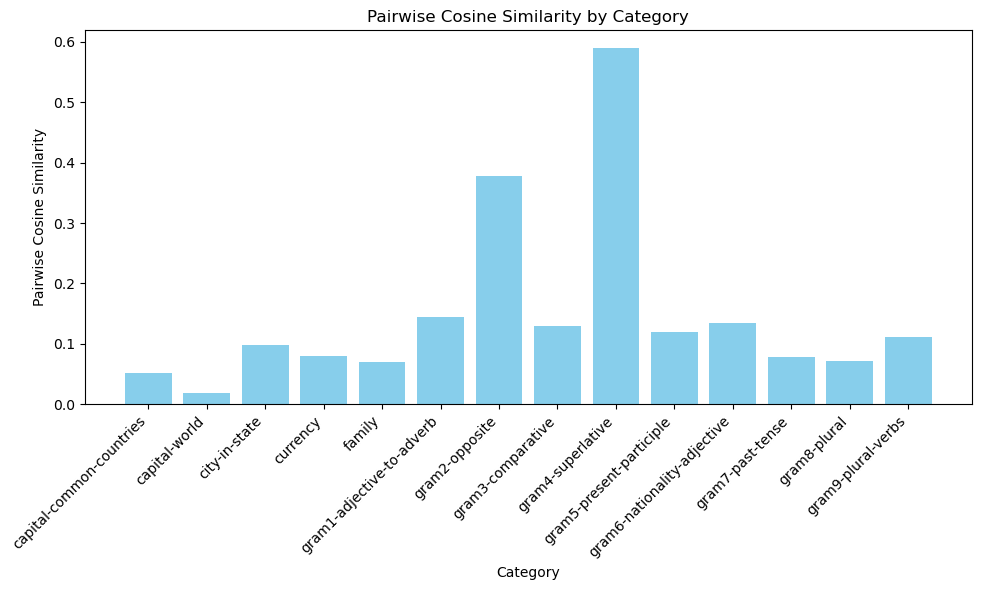

pythia-160m


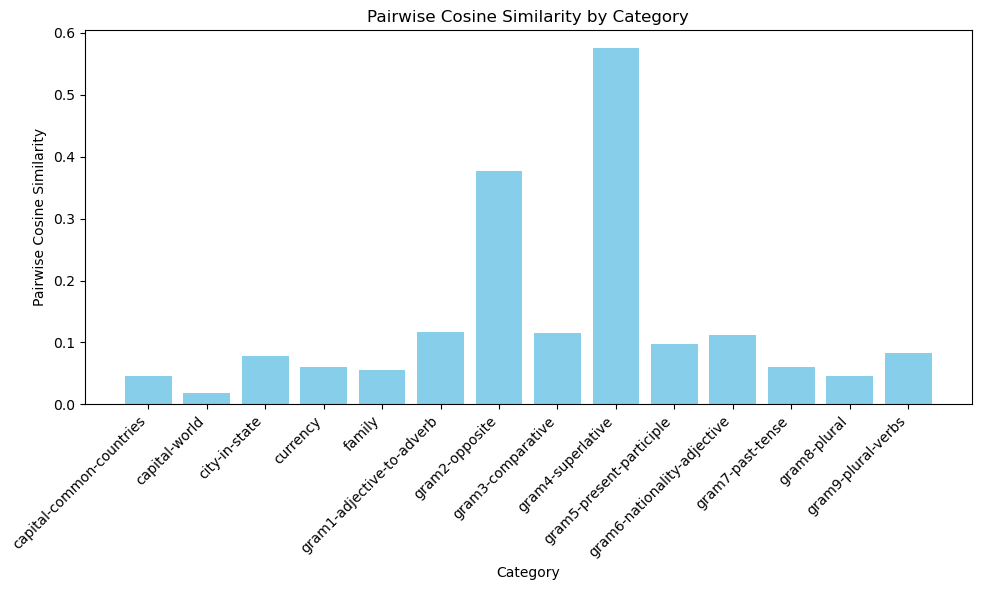

pythia-410m


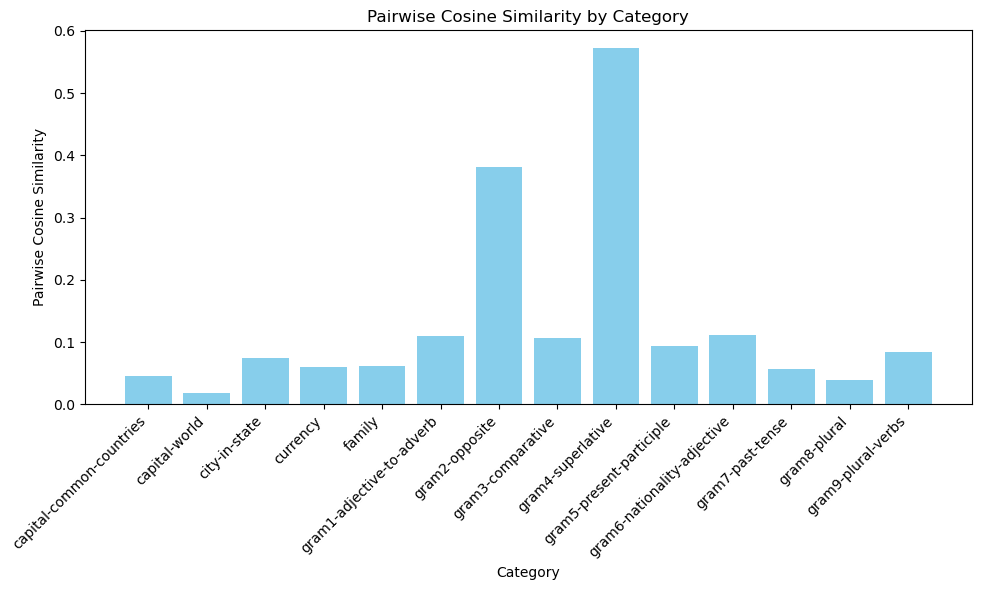

pythia-1b


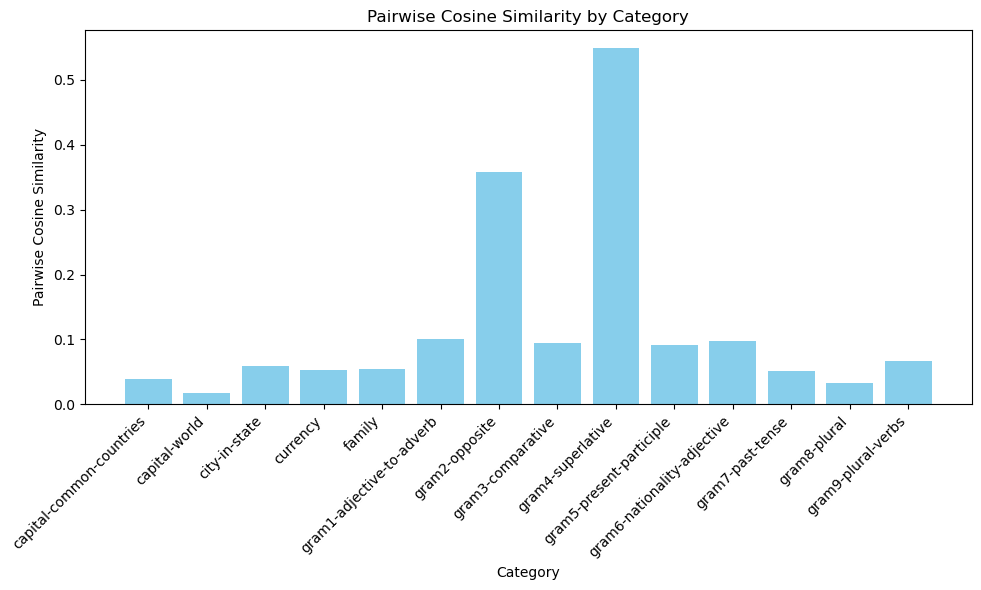

pythia-1.4b


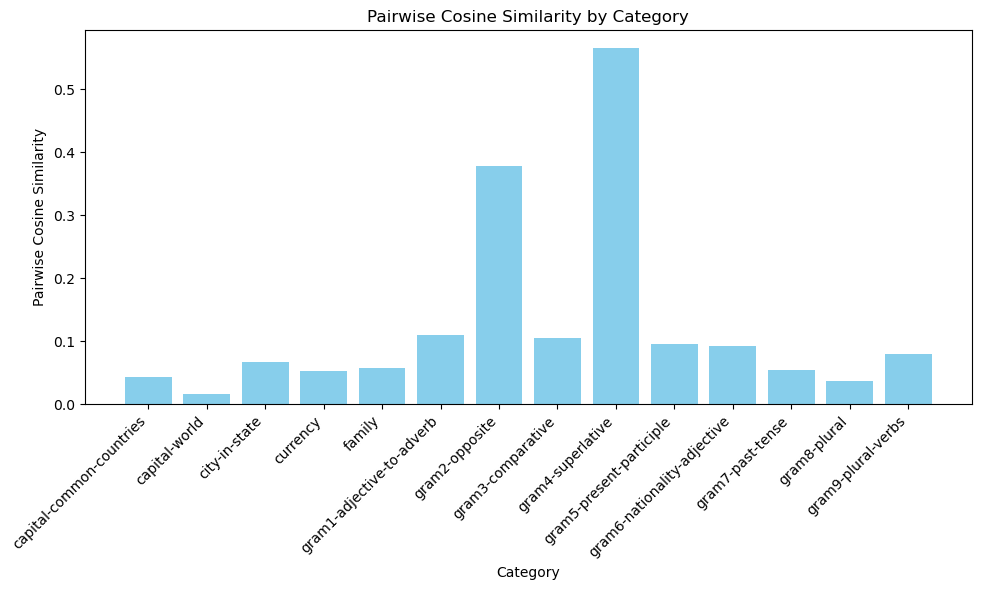

pythia-2.8b


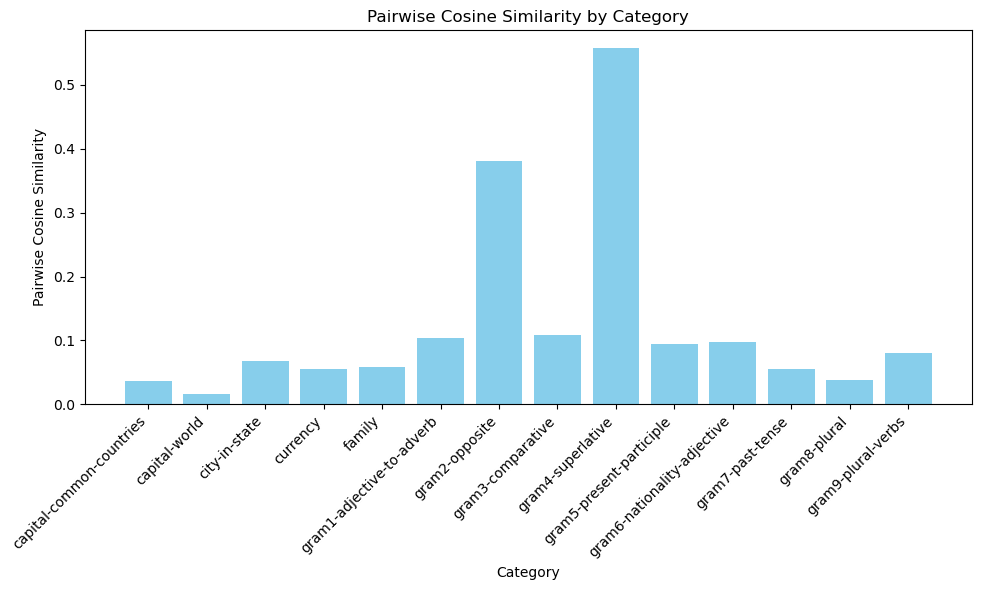

pythia-6.9b


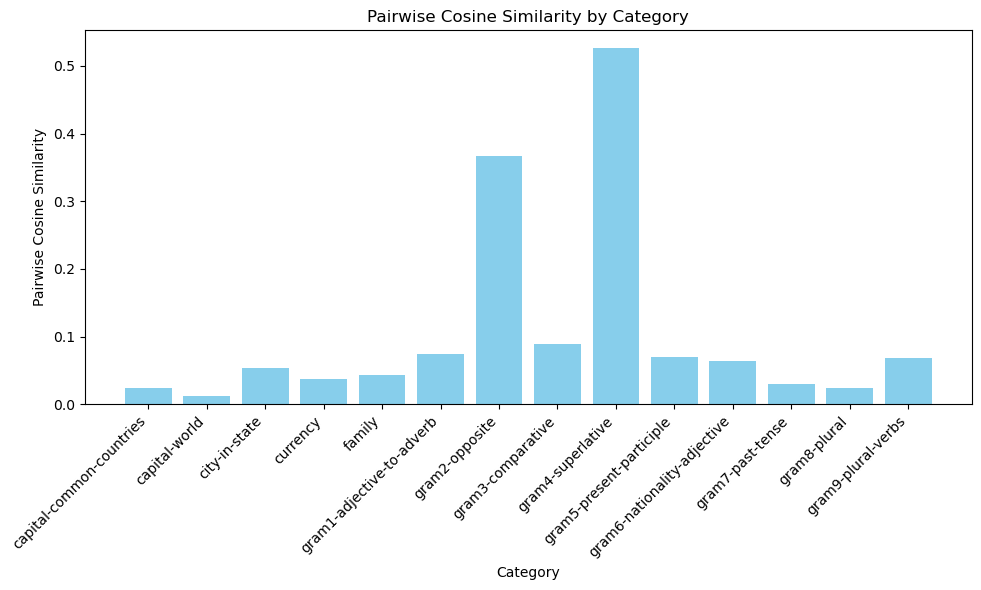

pythia-12b


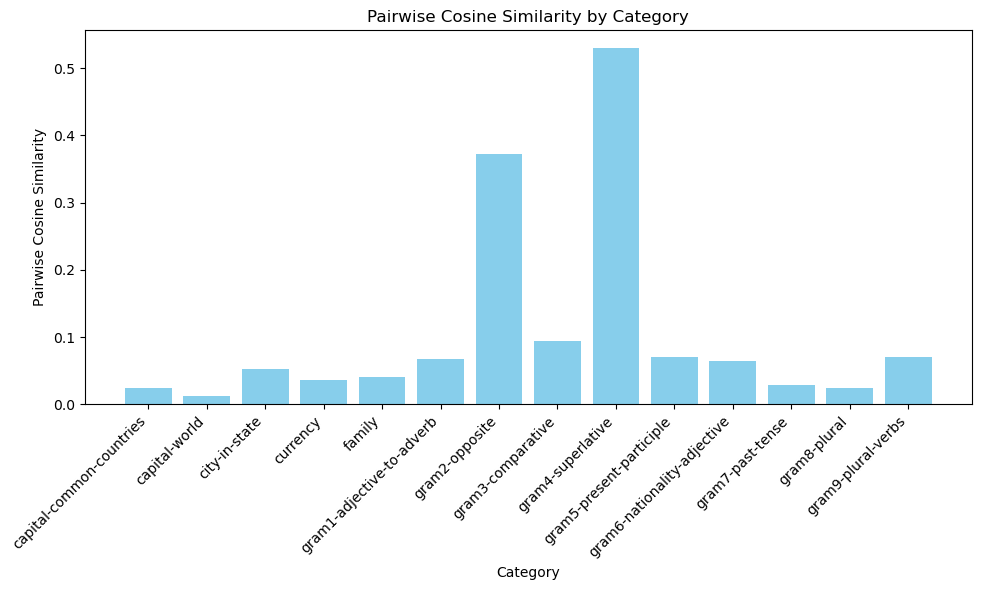

In [168]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
for model_name in model_names:
    print(model_name)
    embedding = get_saved_embedding(f'../embeddings/{model_name}.pth', device=device)
    word_embedding_dict = get_unique_words_embeddings(tokenizer=AutoTokenizer.from_pretrained('EleutherAI/gpt-neox-20b'), embedding=embedding)
    scores = evaluate_word_embeddings(word_embedding_dict)
    plot_single_scores(scores)